# Tema 5: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 clase din setul [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara. 
Modificarile pe care trebuie sa le aveti in vedere sunt:
1. In definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

1. Optional:
    1. Folositi alt optimizator decat SGD, de ex. Adam. Comparati cu rezultatele obtinute pe SGD.
    1. Prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare; intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Predarea acestei aplicatii se va face până in data **16 decembrie, ora 20:00**, in cadrul assignementului temei 3 de pe platforma. Modul de predare si de prezentare este la fel ca pentru temele precedente.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class FashionDataset(Dataset):
    def __init__(self, filepath):
        data = pd.read_csv(filepath)
        images = data.iloc[:, 1:].values
        labels = data.iloc[:, 0].values
        
        self.x = torch.tensor(images)
        self.y = torch.tensor(labels)
        self.x = self.x / 255.0
        self.y = F.one_hot(self.y, num_classes=10).to(float)
            
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
        

In [3]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 100)
        self.Matrix2 = nn.Linear(100, 50)
        self.Matrix3 = nn.Linear(50, 10)
        self.R = nn.ReLU()
        
    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()
        

In [4]:
fashion_train_ds = FashionDataset('./data/fashion-mnist_train.csv')
fashion_test_ds = FashionDataset('./data/fashion-mnist_test.csv')

In [5]:
fashion_train_dl = DataLoader(fashion_train_ds, batch_size = 6)
fashion_test_dl = DataLoader(fashion_test_ds, batch_size = 6)

In [6]:
f = BinaryLogisticRegression()

In [7]:
def train_model(dl, f, n_epochs=20):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad() 
            loss_value = L(f(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [8]:
epoch_data, loss_data = train_model(fashion_train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

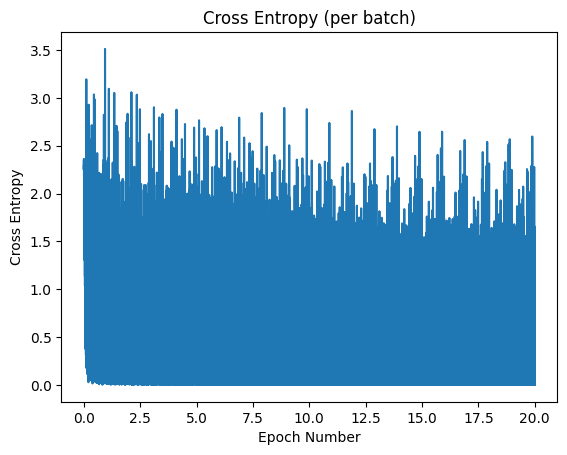

In [9]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (per batch)')

In [10]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

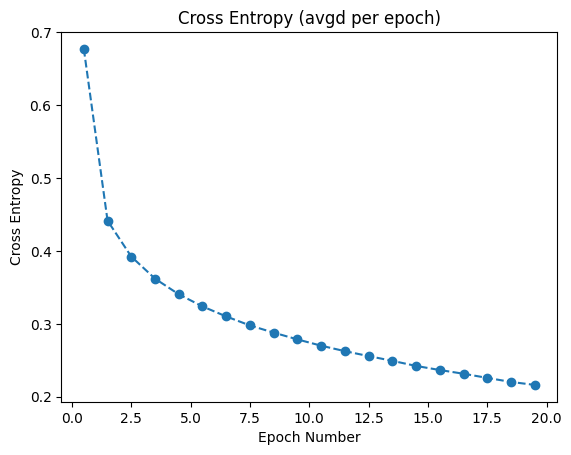

In [11]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

In [12]:
xs, ys = fashion_train_ds[0:2000]
y_hats = f(xs).argmax(axis=1)

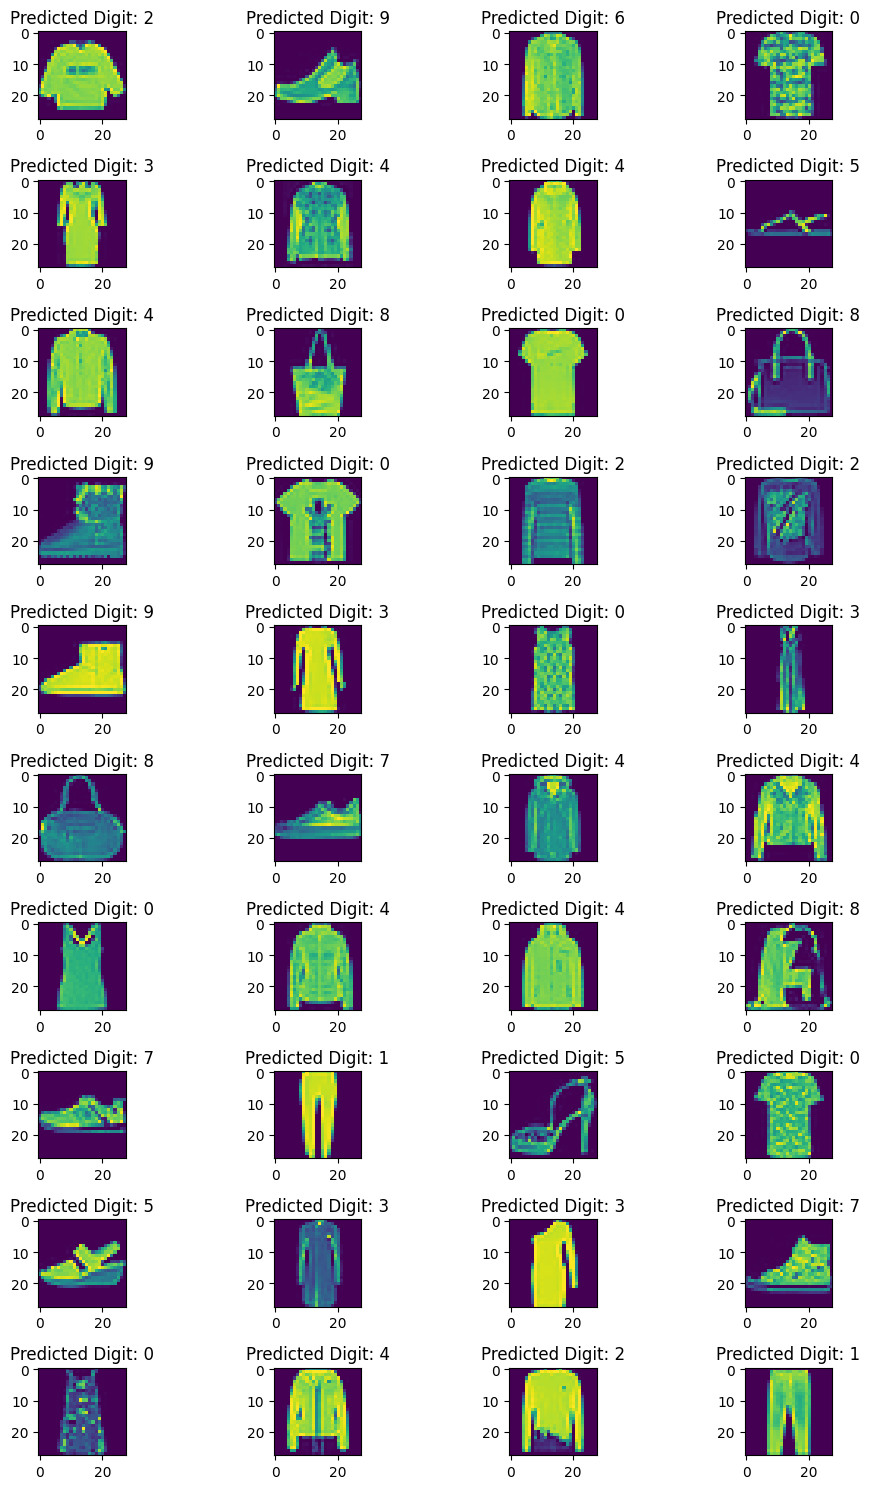

In [13]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i].reshape(28,28))
    plt.title(f'Predicted Digit: {y_hats[i]}')
fig.tight_layout()
plt.show()

In [14]:
import tableprint as tab

In [15]:
confusion = confusion_matrix(np.argmax(ys, axis=1), y_hats)

k = len(confusion) 
headers = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] 
table = []
for i in range(k):
    table.append([f'act: {i}'] + list(confusion[i, :]) + [np.sum(confusion[i, :])])
table.append(['all p'] + list(np.sum(confusion, axis=0)) + [np.sum(confusion)])

tab.table(table, headers, width=6)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    190 │      1 │      1 │      1 │      0 │      0 │     19 │      0 │      2 │      0 │    214 │
│ act: 1 │      0 │    194 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │    194 │
│ act: 2 │      2 │      1 │    167 │      3 │     20 │      0 │     17 │      0 │      0 │      0 │    210 │
│ act: 3 │      3 │      0 │      0 │    202 │      3 │      0 │      3 │      0 │      0 │      0 │    211 │
│ act: 4 │      0 │      0 │      8 │      8 │    189 │      0 │     13 │      0 │      0 │      0 │    218 │
│ act: 5 │      0 │      0 │      0 │      0 │      0 │    176 │      0 │      2 │      0 │      0 │    178 │
│ act: 6 │

In [16]:
xs, ys = fashion_test_ds[:2000]
y_hats = f(xs).argmax(axis=1)

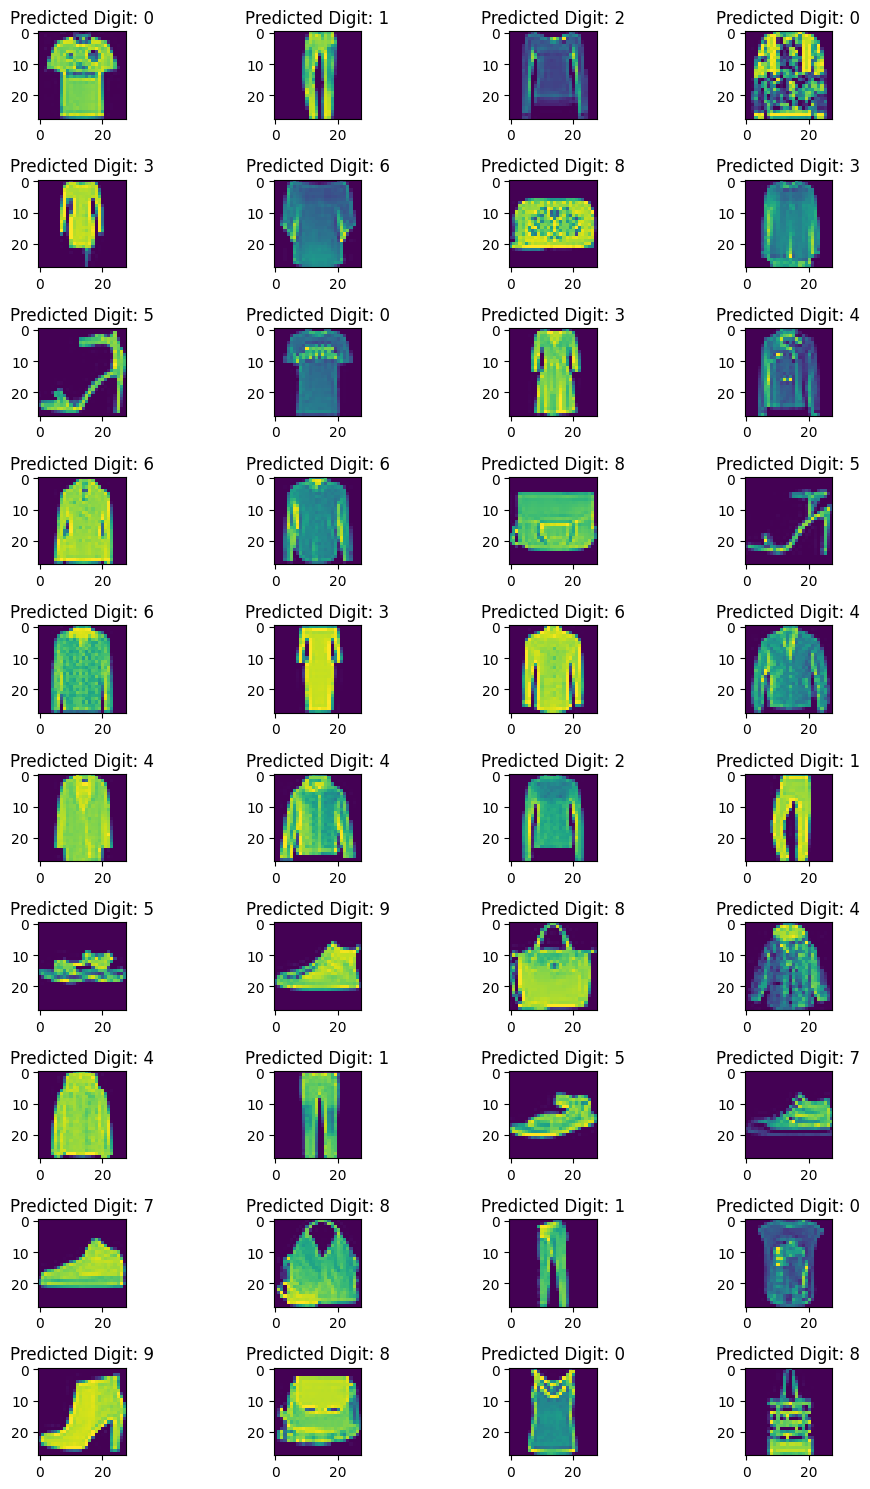

In [17]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i].reshape(28, 28))
    plt.title(f'Predicted Digit: {y_hats[i]}')
fig.tight_layout()
plt.show()